In [ ]:
!pip install datasets transformers scikit-learn -q
from datasets import load_dataset

dataset = load_dataset("mteb/amazon_polarity")

train_ds = dataset["train"].shuffle(seed=42).select(range(5000))
test_ds  = dataset["test"].shuffle(seed=42).select(range(1000))

print(len(train_ds), len(test_ds))



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3599994 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

5000 1000


HITUNG PANJANG TEKS

In [ ]:
def add_length(example):
    example["text_length"] = len(example["text"].split())
    return example

train_ds = train_ds.map(add_length)
test_ds = test_ds.map(add_length)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

KATEGORI PANJANG TEKS

In [ ]:
def length_category(x):
    if x < 50:
        return "short"
    elif x < 150:
        return "medium"
    else:
        return "long"

train_ds = train_ds.map(lambda x: {
    "length_category": length_category(x["text_length"])
})
test_ds = test_ds.map(lambda x: {
    "length_category": length_category(x["text_length"])
})


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

MODEL 1 — DNN (TF-IDF + MLP)

In [ ]:
import numpy as np
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

vectorizer = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2),
    min_df=2,
    stop_words="english"
)

X_train = vectorizer.fit_transform(train_ds["text"])
X_test  = vectorizer.transform(test_ds["text"])

y_train = train_ds["label"]
y_test  = test_ds["label"]

#Definisi Model DNN (MLP)
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    max_iter=100,
    early_stopping=True,
    random_state=SEED
)

mlp.fit(X_train, y_train)




MLPClassifier(early_stopping=True, hidden_layer_sizes=(256, 128), max_iter=100,
              random_state=42)

Evaluasi Model DNN

In [ ]:
preds_dnn = mlp.predict(X_test)

dnn_accuracy = accuracy_score(y_test, preds_dnn)
dnn_f1 = f1_score(y_test, preds_dnn, average="macro")

print("DNN Accuracy:", dnn_accuracy)
print("DNN Macro-F1:", dnn_f1)
print("\nClassification Report (DNN):")
print(classification_report(y_test, preds_dnn))


DNN Accuracy: 0.849
DNN Macro-F1: 0.8479525450830774

Classification Report (DNN):
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       487
           1       0.82      0.91      0.86       513

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



MODEL 2 — BERT

In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding=True,
        max_length=128
    )

tokenized_train = train_ds.map(tokenize, batched=True)
tokenized_test  = test_ds.map(tokenize, batched=True)


tokenized_train.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)
tokenized_test.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


#load model bert
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics BERT

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }


Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    seed=SEED,
    logging_steps=50,
    report_to="none"
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

bert_eval = trainer.evaluate()

print("BERT Accuracy:", bert_eval["eval_accuracy"])
print("BERT Macro-F1:", bert_eval["eval_macro_f1"])


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.211900,0.213921,0.937000,0.936939
2,0.147600,0.239229,0.938000,0.937998
3,0.054000,0.278897,0.945000,0.944960


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


BERT Accuracy: 0.945
BERT Macro-F1: 0.9449598757494213


EVALUASI PER PANJANG TEKS

In [ ]:
def add_length_category(example):
    l = len(example["text"].split())
    if l < 50:
        example["length_category"] = "short"
    elif l < 150:
        example["length_category"] = "medium"
    else:
        example["length_category"] = "long"
    return example

test_ds = test_ds.map(add_length_category)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

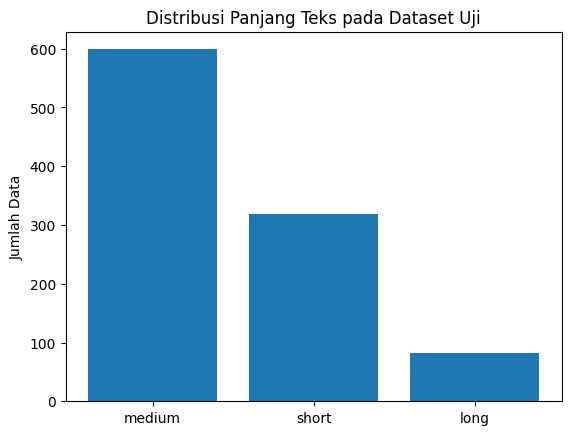

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt


counts = Counter(test_ds["length_category"])

plt.figure()
plt.bar(counts.keys(), counts.values())
plt.ylabel("Jumlah Data")
plt.title("Distribusi Panjang Teks pada Dataset Uji")
plt.show()


BERT VS DNN

In [ ]:
# ===== DNN =====
preds_dnn = mlp.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

dnn_accuracy = accuracy_score(y_test, preds_dnn)
dnn_f1 = f1_score(y_test, preds_dnn, average="macro")

print("DNN Accuracy:", dnn_accuracy)
print("DNN Macro-F1:", dnn_f1)

# ===== BERT =====
bert_eval = trainer.evaluate()

bert_accuracy = bert_eval["eval_accuracy"]
bert_f1 = bert_eval["eval_macro_f1"]

print("BERT Accuracy:", bert_accuracy)
print("BERT Macro-F1:", bert_f1)


DNN Accuracy: 0.849
DNN Macro-F1: 0.8479525450830774


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


BERT Accuracy: 0.945
BERT Macro-F1: 0.9449598757494213


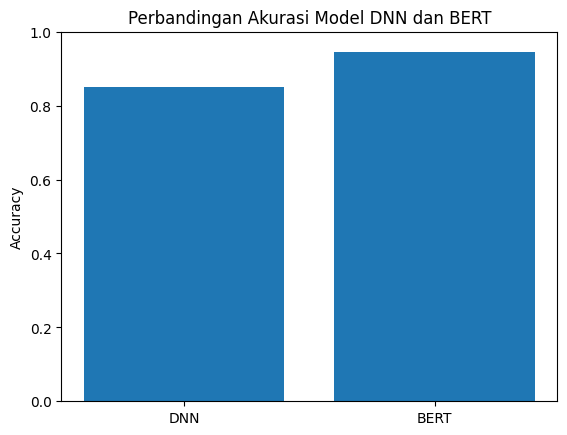

In [ ]:
import matplotlib.pyplot as plt

models = ["DNN", "BERT"]
accuracies = [dnn_accuracy, bert_accuracy]

plt.figure()
plt.bar(models, accuracies)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Perbandingan Akurasi Model DNN dan BERT")
plt.show()
